In [106]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import random
import glob
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from numpy import expand_dims, argmax

%matplotlib inline

### **Pre-processing test images**

In [107]:
test_image_paths_list = []
test = []
for img_path in glob.glob(os.path.join('../input/test-images/TestImages/TestImages', '*.jpg')):
    test_image_paths_list.append(str(img_path))        
print("Total test images : ",len(test_image_paths_list))

for i, img in enumerate(test_image_paths_list):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    test.append(resized_img)
    
test = np.array(test)
test = test.astype('float32')
test /= 255.

Total test images :  35


### **Pre-processing Potsdam dataset**

In [108]:
flat_random = random.sample(range(1, 4000), 200)
gable_random = random.sample(range(1, 4000), 200)
hip_random = random.sample(range(1, 4000), 200)
print(flat_random)
print(gable_random)
print(hip_random)

[2421, 146, 2327, 3, 2397, 1753, 1538, 2708, 1451, 3861, 3783, 1413, 1868, 1836, 3034, 2568, 2479, 1098, 3582, 587, 1501, 3019, 160, 3248, 2154, 1317, 2668, 1496, 2592, 793, 1706, 1864, 3555, 3540, 3424, 532, 98, 3189, 1133, 1564, 1355, 1248, 3585, 3631, 3236, 3008, 2642, 1958, 1785, 421, 877, 2382, 3616, 3600, 1245, 2631, 490, 2074, 1896, 3045, 3657, 2075, 3373, 410, 3816, 2375, 2801, 2902, 334, 1988, 517, 995, 1270, 1298, 1969, 550, 270, 95, 2667, 2921, 3277, 3226, 2611, 2552, 3566, 1403, 3565, 171, 569, 2535, 1869, 3858, 864, 3714, 2057, 2480, 3380, 529, 239, 2265, 2838, 690, 136, 1141, 1488, 3698, 3051, 998, 3395, 2015, 3140, 1788, 3918, 973, 786, 3298, 993, 1881, 2620, 1407, 2240, 2508, 1286, 775, 2454, 1097, 836, 652, 1837, 3197, 2582, 2879, 461, 3453, 3694, 3557, 1561, 970, 3138, 1105, 2163, 3706, 1096, 1615, 2361, 2013, 2830, 1641, 279, 76, 3974, 2798, 2556, 2974, 2389, 2614, 2054, 2736, 2812, 3023, 1452, 1369, 3890, 2095, 1907, 2750, 1225, 3564, 546, 1962, 3344, 1446, 133, 232

In [109]:
potsdam_image_paths_list = []
potsdam_image_labels = []
image_path_flat = '../input/potsdam-full/potsdam-roofs/Dataset 2/Flat/'
image_path_gable = '../input/potsdam-full/potsdam-roofs/Dataset 2/Gable/'
image_path_hip = '../input/potsdam-full/potsdam-roofs/Dataset 2/Hip/'

for i in range(len(flat_random)):
    potsdam_image_paths_list.append(image_path_flat + "Flat" + str(flat_random[i]) + ".tif")
    potsdam_image_labels.append(0)
    
for i in range(len(gable_random)):
    potsdam_image_paths_list.append(image_path_gable + "Gable" + str(gable_random[i]) + ".tif")
    potsdam_image_labels.append(1)
    
for i in range(len(hip_random)):
    potsdam_image_paths_list.append(image_path_hip + "Hip" + str(hip_random[i]) + ".tif")
    potsdam_image_labels.append(2)
# print(image_paths_list)

In [110]:
zipped_list = list(zip(potsdam_image_paths_list, potsdam_image_labels))
random.shuffle(zipped_list)
potsdam_image_paths_list, potsdam_image_labels = zip(*zipped_list)
potsdam_image_paths_list, potsdam_image_labels = list(potsdam_image_paths_list), list(potsdam_image_labels)

In [111]:

train_X_potsdam = []
train_Y_potsdam = []
for i, img in enumerate(potsdam_image_paths_list):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X_potsdam.append(resized_img)
    
train_Y_potsdam = potsdam_image_labels

In [112]:
train_X_potsdam = np.array(train_X_potsdam)
train_Y_potsdam = np.array(train_Y_potsdam)

train_X_potsdam = train_X_potsdam.astype('float32')
train_X_potsdam /= 255.
train_Y_potsdam = train_Y_potsdam.reshape(train_Y_potsdam.shape[0],1)
train_Y_potsdam = to_categorical(train_Y_potsdam, num_classes = 3)

print(train_X_potsdam.shape, train_Y_potsdam.shape)

(600, 256, 256, 3) (600, 3)


### **Make predictions**

In [113]:
def make_predictions(model, test_X, test_Y):
    test_loss = model.evaluate(test_X, test_Y)
    predictions = model.predict(test_X)
    pred_labels = np.argmax(predictions, axis = 1)
    test_labels = np.argmax(test_Y, axis = 1)
    return pred_labels, test_labels

### **Plot confusion matrix**

In [114]:
def plot_confusion_matrix(test_labels, pred_labels):
    Y_test_actual = test_labels
    Y_test_pred = pred_labels
    confusion_mtx = confusion_matrix(Y_test_actual, Y_test_pred) 

    f,ax = plt.subplots(figsize = (8, 8))
    sns.heatmap(confusion_mtx, annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.1f', ax = ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### **Classification Report**

In [115]:
def print_classification_report(test_labels, pred_labels):
    print("Classification Report: ")
    print(classification_report(test_labels, pred_labels))

### **Plot AUC-ROC graph**

In [116]:
def plot_AUC_ROC(model, test_X, test_Y):

    predictions = model.predict(test_X) 

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("ROC_AUC score for 3 models: {0}".format(roc_auc))

    # Plot of a ROC curve for a specific class
    for i in range(3):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

### **Testing on ResNet model**

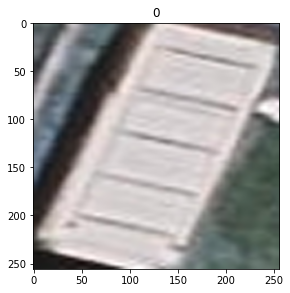

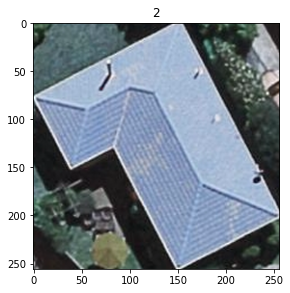

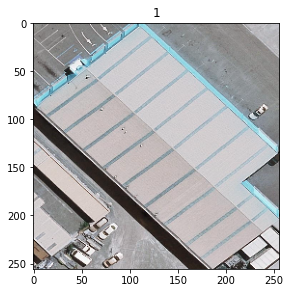

In [117]:
rows = 3
columns = 1
count = 1

ResNet = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/ResNet50-50epochs-bs8-mod2')
for i in range(3,6,1):
    fig = plt.figure(figsize=(15,15))

    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    predictions_ResNet = ResNet.predict(X)
    pred_labels_ResNet = np.argmax(predictions_ResNet, axis = 1)
    
    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,count)
    plt.imshow(img)
    plt.title(pred_labels_ResNet[0])
    
    count += 1
    
plt.show()

19/19 [==============================] - 51s 3s/step - loss: 1.0165 - acc: 0.6767
[0 1 0 1 0 0 2 0 2 1 1 1 2 2 0 0 1 2 1 0 0 1 2 0 1 2 1 0 0 1 2 0 0 1 1 0 1
 0 0 2 0 0 0 0 0 1 1 2 0 0 2 2 1 0 0 2 0 0 2 0 2 0 0 1 0 2 1 1 2 2 0 0 2 1
 0 1 0 0 0 0 1 2 0 1 2 0 0 0 2 2 2 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1
 1 0 0 0 2 1 2 0 2 0 1 2 0 2 2 2 1 1 1 0 1 2 0 0 2 2 1 2 2 1 0 2 0 0 2 0 1
 0 0 1 0 0 2 1 0 1 0 1 1 0 0 0 1 0 0 2 0 1 2 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0
 1 1 2 2 0 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 2 1 1 0 1 0 2 0 0 0 0 1 1 2 1 0 1
 1 0 1 1 1 2 0 0 0 1 2 2 0 2 1 1 0 0 2 2 1 1 0 1 2 0 0 0 2 0 1 0 0 2 2 0 0
 0 2 1 1 2 1 0 1 0 1 0 0 0 2 0 0 1 2 0 0 2 0 1 1 0 0 1 0 2 0 1 2 0 0 0 0 2
 1 1 2 2 2 0 1 0 0 0 0 1 1 1 0 1 2 0 0 0 2 1 0 1 1 0 0 0 2 0 0 2 0 2 0 2 0
 0 2 0 0 0 1 2 2 1 1 0 0 0 0 1 1 2 2 0 2 2 0 2 0 0 0 1 2 1 0 1 0 0 0 1 2 1
 0 2 2 0 1 1 0 1 0 0 1 1 1 0 0 0 2 0 0 1 1 1 1 1 1 0 2 0 0 0 1 2 2 0 0 1 0
 0 1 0 1 1 0 0 2 0 1 1 0 1 1 2 2 0 1 0 1 0 1 2 2 0 0 0 0 2 2 0 0 0 0 0 0 1
 0 0 0 0 0 2 0 2 2

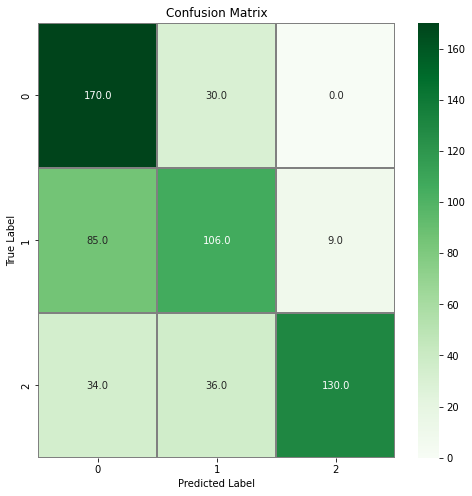

ROC_AUC score for 3 models: {0: 0.8744625, 1: 0.7849750000000001, 2: 0.935725}


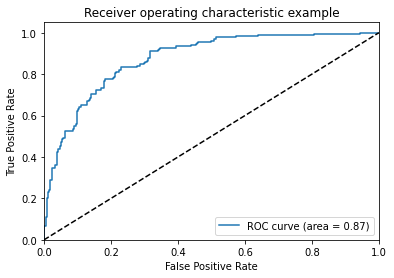

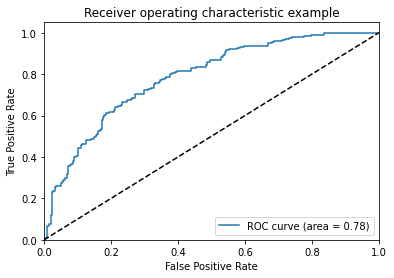

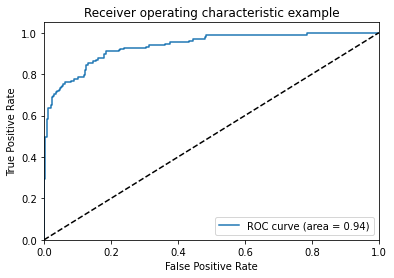

In [118]:
ResNet = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/ResNet50-50epochs-bs8-mod2')
test_loss_ResNet = ResNet.evaluate(train_X_potsdam, train_Y_potsdam)
predictions_ResNet = ResNet.predict(train_X_potsdam)
pred_labels_ResNet = np.argmax(predictions_ResNet, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels_ResNet)
print(test_labels)
print(test_loss_ResNet)
print_classification_report(test_labels, pred_labels_ResNet)
plot_confusion_matrix(test_labels, pred_labels_ResNet)
plot_AUC_ROC(ResNet, train_X_potsdam, train_Y_potsdam)

### **Testing with shallow CNN**

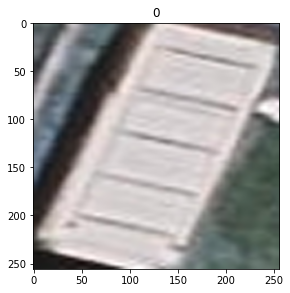

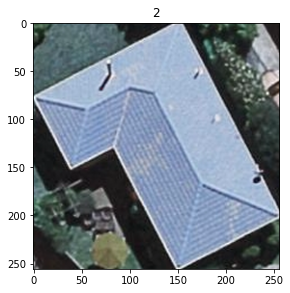

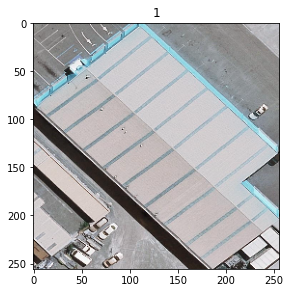

In [119]:
rows = 3
columns = 1
count = 1

CNN = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/CNN-RMSProp-50epochs-mod2')
for i in range(3,6,1):
    fig = plt.figure(figsize=(15,15))

    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    predictions_CNN = CNN.predict(X)
    pred_labels_CNN = np.argmax(predictions_CNN, axis = 1)
    
    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,count)
    plt.imshow(img)
    plt.title(pred_labels_CNN[0])
    
    count += 1
    
plt.show()

19/19 [==============================] - 61s 3s/step - loss: 1.2594 - acc: 0.4667
[2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 2 0 2 2 2 1 0 0 2 2 2 0 2 2 2 2
 0 2 2 0 2 2 0 0 1 2 2 0 2 2 2 2 0 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 0 2 2 0 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 0 2 2 0 2 2
 2 2 2 0 2 2 2 1 2 0 2 2 2 2 2 2 0 0 2 0 2 2 2 0 2 2 2 2 0 0 2 2 2 2 2 0 2
 0 2 2 2 0 2 0 2 2 2 0 2 2 2 1 2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 2 0
 0 2 2 2 0 2 0 2 2 0 0 2 0 2 2 2 0 2 2 2 2 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 0 2 0 2 2 2 0
 2 2 0 2 2 2 0 2 2 2 0 0 0 2 2 0 2 2 0 0 2 2 2 2 0 2 2 2 2 0 0 0 2 2 2 2 2
 2 2 2 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 1
 2 2 2 2 2 0 2 0 2 2 2 1 2 2 1 2 2 2 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 0 2 2 2
 2 1 2 2 2 2 2 2 0 2 0 2 0 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2
 0 2 2 2 0 0 2 2 2

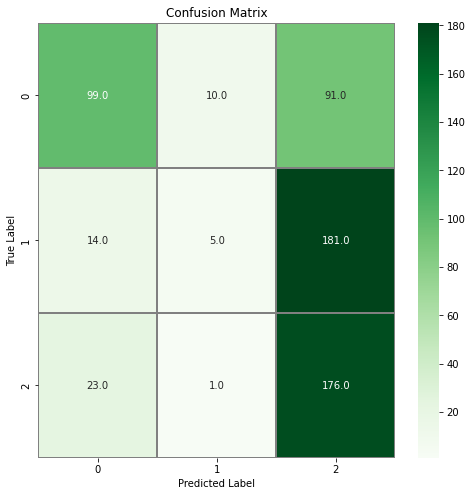

ROC_AUC score for 3 models: {0: 0.8744625, 1: 0.7849750000000001, 2: 0.935725}


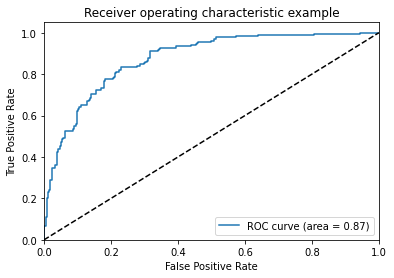

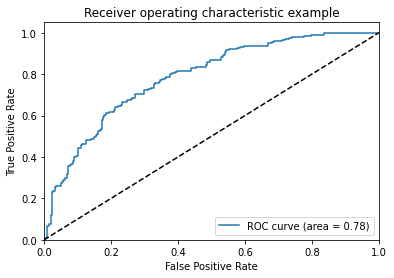

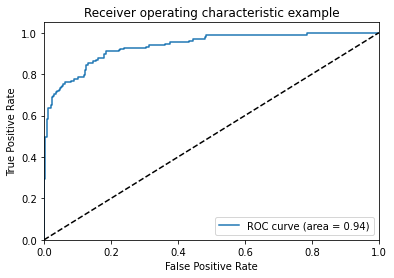

In [120]:
CNN = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/CNN-RMSProp-50epochs-mod2')
test_loss_CNN = CNN.evaluate(train_X_potsdam, train_Y_potsdam)
predictions_CNN = CNN.predict(train_X_potsdam)
pred_labels_CNN = np.argmax(predictions_CNN, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels_CNN)
print(test_labels)
print(test_loss_CNN)
print_classification_report(test_labels, pred_labels_CNN)
plot_confusion_matrix(test_labels, pred_labels_CNN)
plot_AUC_ROC(ResNet, train_X_potsdam, train_Y_potsdam)

### **Testing with EfficientNetB4 - RMS Prop**

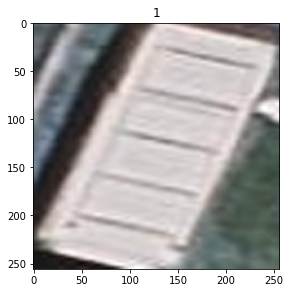

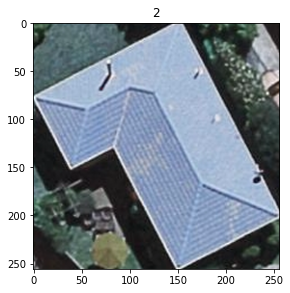

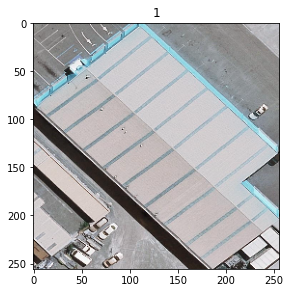

In [121]:
rows = 3
columns = 1
count = 1

EfficientNetRMS = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/EfficientNetB4-50epochs-bs16-RMS-mod2')
for i in range(3,6,1):
    fig = plt.figure(figsize=(15,15))

    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    predictions_EfficientNetRMS = EfficientNetRMS.predict(X)
    pred_labels_EfficientNetRMS = np.argmax(predictions_EfficientNetRMS, axis = 1)
    
    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,count)
    plt.imshow(img)
    plt.title(pred_labels_EfficientNetRMS[0])
    
    count += 1
    
plt.show()

19/19 [==============================] - 45s 2s/step - loss: 0.7644 - acc: 0.6533
[1 0 2 1 2 2 2 1 2 0 0 2 2 2 0 1 0 2 0 0 0 2 0 0 2 2 1 0 0 1 1 2 0 0 1 2 2
 0 0 2 0 1 2 2 0 1 2 2 0 0 2 2 2 0 0 2 0 0 2 1 1 0 1 1 2 2 0 1 2 2 0 0 2 2
 0 0 1 1 1 1 1 2 2 1 2 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 1 2 1 0 1 1 1 0 1
 2 0 1 0 2 2 2 0 2 0 1 2 0 1 0 0 2 0 2 0 1 2 1 0 1 1 2 2 1 1 0 1 0 2 2 0 2
 0 0 1 2 0 2 0 1 0 0 1 0 0 2 1 1 0 0 2 0 1 2 1 0 0 0 2 2 1 2 2 0 0 0 0 1 2
 0 0 2 2 1 2 0 2 2 0 0 0 1 0 2 2 1 0 0 0 2 0 1 1 1 1 2 1 1 1 0 1 0 2 2 0 1
 1 2 2 1 1 2 0 2 2 0 2 2 0 2 0 2 1 0 2 2 1 0 0 1 2 0 0 0 2 1 1 0 0 2 2 0 0
 0 1 1 1 1 1 0 1 0 1 0 0 0 2 0 0 1 2 0 0 2 1 0 2 0 1 1 0 1 2 0 0 0 0 2 2 2
 2 1 2 2 2 1 1 0 0 0 0 0 1 1 0 1 2 1 0 0 2 2 1 2 1 1 0 0 2 0 1 2 2 2 1 2 1
 0 1 0 1 0 0 1 2 2 0 0 0 2 2 1 1 2 0 2 2 2 0 1 1 0 0 0 2 0 0 1 0 2 0 1 2 1
 0 2 2 2 1 2 2 0 0 0 1 0 0 2 1 2 2 0 2 2 1 0 0 1 2 1 2 1 0 0 1 2 2 0 0 1 2
 0 1 1 2 1 0 1 1 1 1 2 0 2 1 2 2 2 1 0 1 2 2 2 2 0 2 1 0 2 2 0 0 2 1 1 0 1
 0 0 2 1 0 2 1 2 2

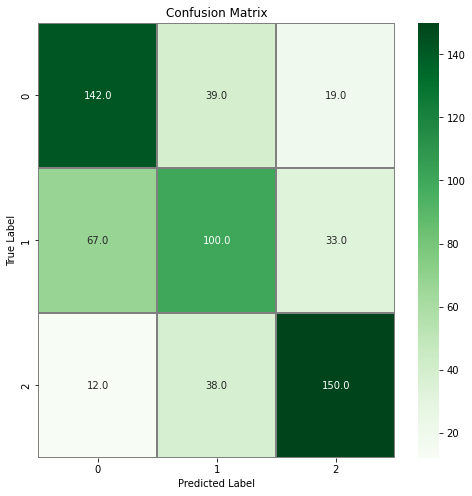

ROC_AUC score for 3 models: {0: 0.8744625, 1: 0.7849750000000001, 2: 0.935725}


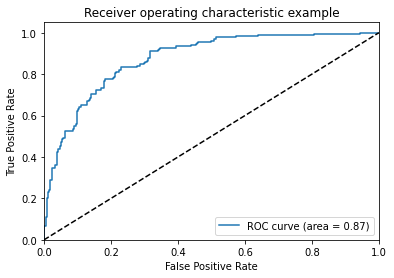

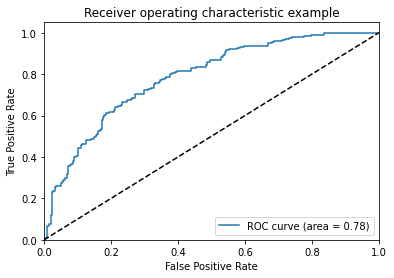

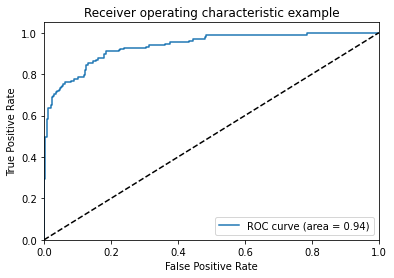

In [122]:
EfficientNetRMS = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/EfficientNetB4-50epochs-bs16-RMS-mod2')
test_loss_EfficientNetRMS = EfficientNetRMS.evaluate(train_X_potsdam, train_Y_potsdam)
predictions_EfficientNetRMS = EfficientNetRMS.predict(train_X_potsdam)
pred_labels_EfficientNetRMS = np.argmax(predictions_EfficientNetRMS, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels_EfficientNetRMS)
print(test_labels)
print(test_loss_EfficientNetRMS)
print_classification_report(test_labels, pred_labels_EfficientNetRMS)
plot_confusion_matrix(test_labels, pred_labels_EfficientNetRMS)
plot_AUC_ROC(ResNet, train_X_potsdam, train_Y_potsdam)

### **Testing with EfficientNetB4 - Adam**

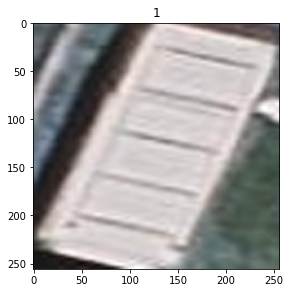

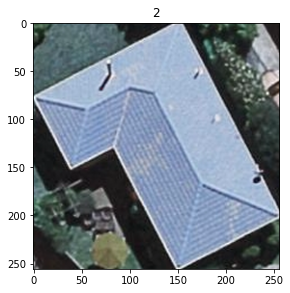

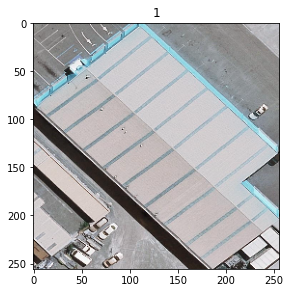

In [123]:
rows = 1
columns = 3
count = 1

EfficientNetAdam = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/EfficientNetB4-50epochs-bs16-Adam-mod2')
for i in range(3,6,1):
    fig = plt.figure(figsize=(15,15))

    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    predictions_EfficientNetAdam = EfficientNetAdam.predict(X)
    pred_labels_EfficientNetAdam = np.argmax(predictions_EfficientNetAdam, axis = 1)
    
    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,count)
    plt.imshow(img)
    plt.title(pred_labels_EfficientNetAdam[0])
    
    count += 1
    
plt.show()

19/19 [==============================] - 42s 2s/step - loss: 0.6737 - acc: 0.6833
[1 1 0 1 0 1 2 0 2 0 0 1 2 2 1 1 0 2 0 0 0 1 1 0 0 2 1 0 1 1 2 1 1 1 1 0 0
 0 0 2 0 0 0 0 0 1 1 2 0 0 2 2 2 0 0 2 0 0 2 1 2 1 1 1 2 2 1 0 2 2 0 0 2 2
 0 0 0 1 1 1 1 2 0 1 2 0 0 2 2 2 1 1 1 1 0 0 0 1 0 0 2 1 1 0 0 0 1 1 1 0 1
 0 0 0 1 2 2 2 0 2 0 1 2 0 1 1 1 1 0 2 0 1 2 0 0 1 2 1 2 1 1 1 1 0 0 2 1 2
 1 0 0 0 0 2 0 0 2 0 1 1 1 2 0 1 0 2 1 0 1 2 1 0 0 0 2 2 2 2 2 0 0 0 0 0 0
 0 1 0 2 1 1 0 2 0 0 0 2 1 2 2 1 1 0 1 0 2 0 1 0 1 0 2 0 0 0 0 1 1 2 1 0 1
 1 2 2 1 1 0 0 0 1 0 2 2 0 2 1 2 0 0 2 2 1 1 0 1 1 0 0 0 2 2 1 0 0 2 2 0 0
 0 2 1 1 0 1 0 1 0 1 0 1 0 2 0 0 0 1 0 0 2 1 2 0 0 1 0 0 2 0 0 2 0 0 2 0 2
 0 1 2 2 2 1 1 0 0 0 0 0 1 1 0 2 2 0 0 0 2 0 1 1 0 0 0 0 2 0 0 2 2 2 0 2 0
 0 0 0 0 0 0 2 1 2 1 1 0 2 0 1 1 2 2 0 2 2 0 1 1 0 0 0 2 2 2 1 0 0 0 1 2 1
 0 1 2 0 1 2 0 0 0 0 0 1 0 0 0 1 2 0 2 0 1 1 1 0 2 1 2 0 1 0 1 2 2 1 0 1 1
 0 1 1 2 1 0 1 2 0 1 2 1 1 1 1 2 0 1 0 1 2 2 2 2 0 0 1 0 2 2 0 0 0 1 1 0 1
 1 0 1 0 0 2 1 2 2

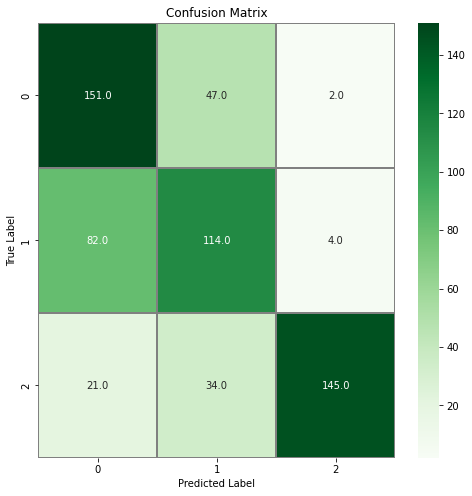

ROC_AUC score for 3 models: {0: 0.8744625, 1: 0.7849750000000001, 2: 0.935725}


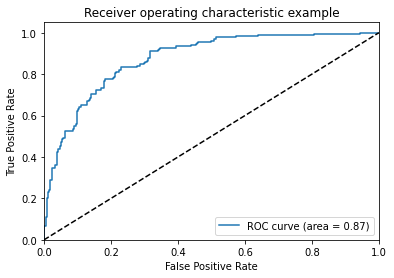

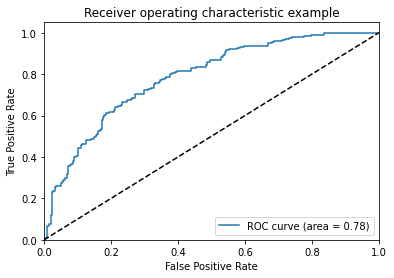

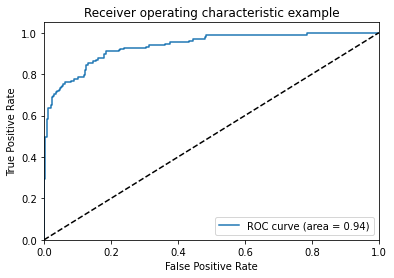

In [124]:
EfficientNetAdam = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/EfficientNetB4-50epochs-bs16-Adam-mod2')
test_loss_EfficientNetAdam = EfficientNetAdam.evaluate(train_X_potsdam, train_Y_potsdam)
predictions_EfficientNetAdam = EfficientNetAdam.predict(train_X_potsdam)
pred_labels_EfficientNetAdam = np.argmax(predictions_EfficientNetAdam, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels_EfficientNetAdam)
print(test_labels)
print(test_loss_EfficientNetAdam)
print_classification_report(test_labels, pred_labels_EfficientNetAdam)
plot_confusion_matrix(test_labels, pred_labels_EfficientNetAdam)
plot_AUC_ROC(ResNet, train_X_potsdam, train_Y_potsdam)

### **Testing with VGG**

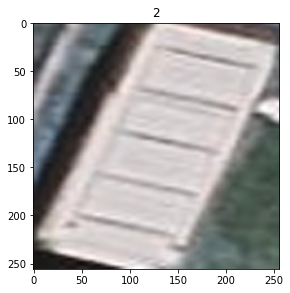

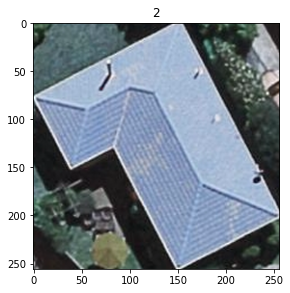

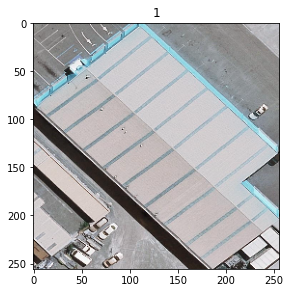

In [125]:
rows = 1
columns = 3
count = 1

VGG = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/VGG16-50epochs-RMS-bs4-mod2')
for i in range(3,6,1):
    fig = plt.figure(figsize=(15,15))

    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    predictions_VGG = VGG.predict(X)
    pred_labels_VGG = np.argmax(predictions_VGG, axis = 1)
    
    fig.add_subplot(rows, columns, count)
    plt.subplot(1,3,count)
    plt.imshow(img)
    plt.title(pred_labels_VGG[0])
    
    count += 1
    
plt.show()

19/19 [==============================] - 174s 9s/step - loss: 0.9858 - acc: 0.7467
[1 2 0 1 1 1 2 0 2 0 2 1 2 2 1 2 1 2 1 0 0 2 1 0 2 2 1 0 0 1 2 0 1 1 1 0 2
 0 2 2 0 1 2 2 0 1 1 2 0 0 2 2 2 0 1 2 1 0 2 1 2 1 0 0 2 2 1 2 2 2 1 0 2 2
 1 0 0 0 0 0 1 2 2 1 2 0 1 2 2 2 2 1 1 1 0 2 0 0 0 2 2 0 1 0 0 2 2 1 1 0 2
 2 0 0 0 2 2 2 0 2 0 1 2 0 2 2 2 2 0 2 0 0 2 0 0 2 2 2 2 2 1 1 2 0 2 2 1 2
 0 0 1 2 0 2 0 1 2 0 1 0 0 2 0 1 0 2 2 0 1 2 2 0 1 0 2 2 2 2 2 2 0 0 1 0 0
 0 1 2 2 0 1 0 2 2 0 0 2 2 0 2 0 1 2 1 0 2 0 1 0 1 1 2 0 0 0 1 2 0 2 2 0 1
 2 2 2 2 1 2 0 0 2 2 2 2 0 2 1 2 2 0 2 2 2 1 0 1 2 0 0 1 2 2 2 0 0 2 2 0 0
 0 2 1 1 2 1 0 1 0 1 0 0 0 2 0 0 1 2 0 0 2 2 2 2 0 2 0 0 2 0 0 2 0 0 2 2 2
 1 1 2 2 2 0 1 0 2 0 2 1 1 2 1 2 2 1 0 0 2 2 2 2 1 2 0 0 2 0 0 2 2 2 2 2 0
 2 2 0 0 0 1 0 2 2 1 0 0 2 1 1 1 2 2 2 2 2 0 2 1 0 2 0 2 2 0 1 0 0 0 1 2 1
 1 2 2 0 1 2 2 1 0 0 1 1 0 0 0 1 2 0 2 1 1 1 1 1 2 2 2 0 1 1 1 2 2 0 0 1 2
 0 1 1 2 1 0 2 2 0 1 2 1 1 1 2 2 2 1 0 1 2 2 2 2 0 0 2 0 2 2 0 0 2 1 0 0 1
 1 1 0 1 0 2 1 2 

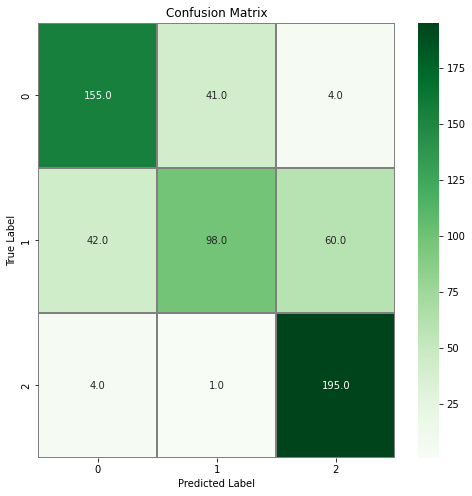

ROC_AUC score for 3 models: {0: 0.8744625, 1: 0.7849750000000001, 2: 0.935725}


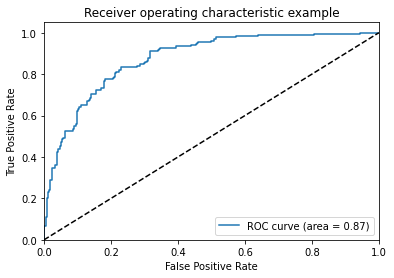

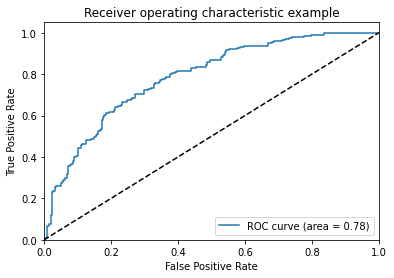

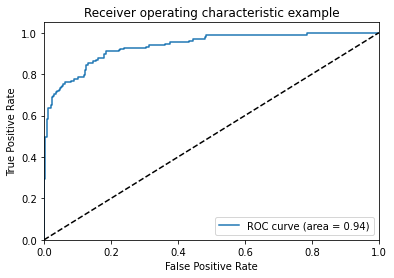

In [126]:
VGG = tf.keras.models.load_model('../input/weight-50epochs-mod-dataset2/weights-50epochs-mod-dataset2/VGG16-50epochs-RMS-bs4-mod2')
test_loss_VGG = VGG.evaluate(train_X_potsdam, train_Y_potsdam)
predictions_VGG = VGG.predict(train_X_potsdam)
pred_labels_VGG = np.argmax(predictions_VGG, axis = 1)
test_labels = np.argmax(train_Y_potsdam, axis = 1)
print(pred_labels_VGG)
print(test_labels)
print(test_loss_VGG)
print_classification_report(test_labels, pred_labels_VGG)
plot_confusion_matrix(test_labels, pred_labels_VGG)
plot_AUC_ROC(ResNet, train_X_potsdam, train_Y_potsdam)

### **Majority Voting**

- Combining ResNet, EfficientNet-RMSProp, EfficientNet-Adam
- First step -> Get results from all 3
- Create 600 * 3 list
- convert to numpy
- then predict max


In [127]:
def majority_voting(preds):
    for i in range(preds.shape[0]):
        count = [0, 0, 0]
        for j in range(preds.shape[1]):
            count[preds[i][j]] += 1
        idxs = count.index(max(count))
        print(count, idxs)
        return idxs

In [128]:
for i in range(0,35,1):
    X = test[i]
    img = X
    X = tf.expand_dims(X, 0)
    
    predictions_CNN_i = CNN.predict(X)
    pred_labels_CNN_i = np.argmax(predictions_CNN_i, axis = 1)
    
    predictions_ResNet_i = ResNet.predict(X)
    pred_labels_ResNet_i = np.argmax(predictions_ResNet_i, axis = 1)
    
    predictions_EfficientNetAdam_i = EfficientNetAdam.predict(X)
    pred_labels_EfficientNetAdam_i = np.argmax(predictions_EfficientNetAdam_i, axis = 1)
    
    predictions_VGG_i = VGG.predict(X)
    pred_labels_VGG_i = np.argmax(predictions_VGG_i, axis = 1)
    
    print('CNN Result:' , pred_labels_CNN_i[0])
    print('ResNet Result:', pred_labels_ResNet_i[0])
    print('EfficientNetB4-Adam Result: ', pred_labels_EfficientNetAdam_i[0])
    print('VGG Result: ', pred_labels_VGG_i[0])
    
    combined_preds_rev = []
    res1 = pred_labels_CNN_i[0]
    res2 = pred_labels_ResNet_i[0]
    res3 = pred_labels_EfficientNetAdam_i[0]
    res4 = pred_labels_VGG_i[0]
    combined_preds_rev.append([res1, res2, res3, res4])   

    combined_preds_rev = np.array(combined_preds_rev)
    print(combined_preds_rev)
    pred_results_rev = majority_voting(combined_preds_rev)
    print("Image {0} belongs to class: {1}\n".format(test_image_paths_list[i].split('/')[5], pred_results_rev))

CNN Result: 1
ResNet Result: 1
EfficientNetB4-Adam Result:  1
VGG Result:  1
[[1 1 1 1]]
[0, 4, 0] 1
Image christchurch_97_118.jpg belongs to class: 1

CNN Result: 1
ResNet Result: 0
EfficientNetB4-Adam Result:  0
VGG Result:  0
[[1 0 0 0]]
[3, 1, 0] 0
Image GHoYp-90691.jpg belongs to class: 0

CNN Result: 1
ResNet Result: 0
EfficientNetB4-Adam Result:  1
VGG Result:  1
[[1 0 1 1]]
[1, 3, 0] 1
Image christchurch_215_19.jpg belongs to class: 1

CNN Result: 0
ResNet Result: 0
EfficientNetB4-Adam Result:  1
VGG Result:  2
[[0 0 1 2]]
[2, 1, 1] 0
Image christchurch_215_396.jpg belongs to class: 0

CNN Result: 2
ResNet Result: 2
EfficientNetB4-Adam Result:  2
VGG Result:  2
[[2 2 2 2]]
[0, 0, 4] 2
Image christchurch_97_216.jpg belongs to class: 2

CNN Result: 1
ResNet Result: 1
EfficientNetB4-Adam Result:  1
VGG Result:  1
[[1 1 1 1]]
[0, 4, 0] 1
Image christchurch_215_274.jpg belongs to class: 1

CNN Result: 0
ResNet Result: 0
EfficientNetB4-Adam Result:  0
VGG Result:  0
[[0 0 0 0]]
[4, 0

600
Shape of combined results: (600, 1, 3)
[1, 2, 0] 1
[1, 2, 0] 1
[2, 0, 1] 0
[0, 3, 0] 1
[2, 0, 1] 0
[1, 1, 1] 0
[0, 0, 3] 2
[2, 1, 0] 0
[0, 0, 3] 2
[2, 1, 0] 0
[2, 1, 0] 0
[0, 2, 1] 1
[0, 0, 3] 2
[0, 0, 3] 2
[2, 1, 0] 0
[1, 2, 0] 1
[2, 1, 0] 0
[0, 0, 3] 2
[2, 1, 0] 0
[3, 0, 0] 0
[3, 0, 0] 0
[0, 2, 1] 1
[1, 1, 1] 0
[3, 0, 0] 0
[1, 1, 1] 0
[0, 0, 3] 2
[0, 3, 0] 1
[3, 0, 0] 0
[2, 1, 0] 0
[0, 3, 0] 1
[0, 1, 2] 2
[1, 1, 1] 0
[2, 1, 0] 0
[1, 2, 0] 1
[0, 3, 0] 1
[2, 0, 1] 0
[1, 1, 1] 0
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[3, 0, 0] 0
[2, 1, 0] 0
[2, 0, 1] 0
[2, 0, 1] 0
[3, 0, 0] 0
[0, 3, 0] 1
[0, 2, 1] 1
[0, 0, 3] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[0, 0, 3] 2
[0, 1, 2] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[1, 2, 0] 1
[0, 1, 2] 2
[2, 1, 0] 0
[1, 2, 0] 1
[0, 3, 0] 1
[1, 0, 2] 2
[0, 0, 3] 2
[1, 2, 0] 1
[1, 2, 0] 1
[0, 0, 3] 2
[0, 0, 3] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[0, 1, 2] 2
[3, 0, 0] 0
[2, 1, 0] 0
[2, 1, 0] 0
[1, 2, 0] 1
[1, 2, 0] 1
[1, 2, 0]

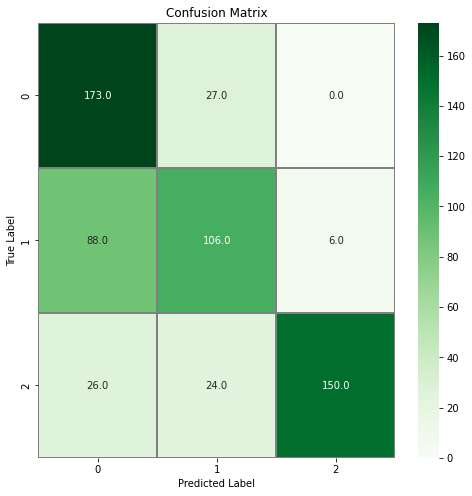

0.715


In [129]:
combined_preds_ree = []
pred_final = []
print(len(pred_labels_ResNet))
for i in range(0,600,1):
    res1 = pred_labels_ResNet[i]
    res2 = pred_labels_EfficientNetRMS[i]
    res3 = pred_labels_EfficientNetAdam[i]
    combined_preds_ree.append([[res1, res2, res3]])
    

combined_preds_ree = np.array(combined_preds_ree)
print("Shape of combined results: {0}".format(combined_preds_ree.shape))

for i in range(0,600,1):
#     print(combined_preds_ree[i])
    pred_results_ree = majority_voting(combined_preds_ree[i])
#     print(pred_results_ree)
    pred_final.append(pred_results_ree)
    
# print(pred_final)
plot_confusion_matrix(test_labels, pred_final)
print(accuracy_score(test_labels, pred_final))

- Combining ResNet, EfficientNet-Adam, VGG
- First step -> Get results from all 3
- Create 600 * 3 list
- convert to numpy
- then predict max

Shape of combined results: (600, 1, 3)
[1, 2, 0] 1
[0, 2, 1] 1
[3, 0, 0] 0
[0, 3, 0] 1
[2, 1, 0] 0
[1, 2, 0] 1
[0, 0, 3] 2
[3, 0, 0] 0
[0, 0, 3] 2
[2, 1, 0] 0
[1, 1, 1] 0
[0, 3, 0] 1
[0, 0, 3] 2
[0, 0, 3] 2
[1, 2, 0] 1
[1, 1, 1] 0
[1, 2, 0] 1
[0, 0, 3] 2
[1, 2, 0] 1
[3, 0, 0] 0
[3, 0, 0] 0
[0, 2, 1] 1
[0, 2, 1] 1
[3, 0, 0] 0
[1, 1, 1] 0
[0, 0, 3] 2
[0, 3, 0] 1
[3, 0, 0] 0
[2, 1, 0] 0
[0, 3, 0] 1
[0, 0, 3] 2
[2, 1, 0] 0
[1, 2, 0] 1
[0, 3, 0] 1
[0, 3, 0] 1
[3, 0, 0] 0
[1, 1, 1] 0
[3, 0, 0] 0
[2, 0, 1] 0
[0, 0, 3] 2
[3, 0, 0] 0
[2, 1, 0] 0
[2, 0, 1] 0
[2, 0, 1] 0
[3, 0, 0] 0
[0, 3, 0] 1
[0, 3, 0] 1
[0, 0, 3] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[0, 0, 3] 2
[0, 1, 2] 2
[3, 0, 0] 0
[2, 1, 0] 0
[0, 0, 3] 2
[2, 1, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[1, 2, 0] 1
[0, 0, 3] 2
[1, 2, 0] 1
[2, 1, 0] 0
[1, 2, 0] 1
[1, 0, 2] 2
[0, 0, 3] 2
[0, 3, 0] 1
[1, 1, 1] 0
[0, 0, 3] 2
[0, 0, 3] 2
[2, 1, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[0, 1, 2] 2
[2, 1, 0] 0
[2, 1, 0] 0
[3, 0, 0] 0
[2, 1, 0] 0
[2, 1, 0] 0
[2, 1, 0] 0
[

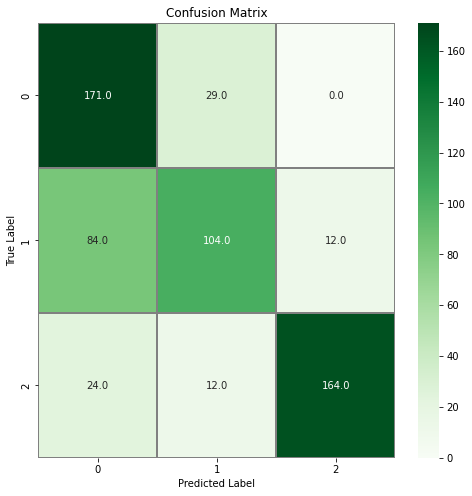

0.7316666666666667


In [130]:
combined_preds_rev = []
pred_final_rev = []
for i in range(0,600,1):
    res1 = pred_labels_ResNet[i]
    res2 = pred_labels_EfficientNetAdam[i]
    res3 = pred_labels_VGG[i]
    combined_preds_rev.append([[res1, res2, res3]])
    

combined_preds_rev = np.array(combined_preds_rev)
print("Shape of combined results: {0}".format(combined_preds_rev.shape))

for i in range(0,600,1):
    pred_results_rev = majority_voting(combined_preds_rev[i])
    pred_final_rev.append(pred_results_rev)
    
plot_confusion_matrix(test_labels, pred_final_rev)
print(accuracy_score(test_labels, pred_final_rev))

- Combining ResNet, EfficientNet-RMSProp, CNN
- First step -> Get results from all 3
- Create 600 * 3 list
- convert to numpy
- then predict max

Shape of combined results: (600, 1, 3)
[1, 1, 1] 0
[0, 2, 1] 1
[2, 0, 1] 0
[0, 2, 1] 1
[3, 0, 0] 0
[1, 1, 1] 0
[0, 0, 3] 2
[2, 0, 1] 0
[0, 0, 3] 2
[1, 1, 1] 0
[1, 1, 1] 0
[0, 2, 1] 1
[0, 0, 3] 2
[0, 0, 3] 2
[1, 1, 1] 0
[1, 1, 1] 0
[2, 1, 0] 0
[0, 0, 3] 2
[2, 1, 0] 0
[2, 0, 1] 0
[3, 0, 0] 0
[0, 2, 1] 1
[1, 1, 1] 0
[2, 0, 1] 0
[1, 1, 1] 0
[0, 0, 3] 2
[0, 3, 0] 1
[3, 0, 0] 0
[2, 1, 0] 0
[0, 2, 1] 1
[0, 0, 3] 2
[1, 1, 1] 0
[2, 1, 0] 0
[0, 2, 1] 1
[0, 2, 1] 1
[2, 0, 1] 0
[1, 1, 1] 0
[3, 0, 0] 0
[2, 0, 1] 0
[0, 0, 3] 2
[3, 0, 0] 0
[2, 0, 1] 0
[2, 0, 1] 0
[3, 0, 0] 0
[3, 0, 0] 0
[0, 3, 0] 1
[0, 2, 1] 1
[0, 0, 3] 2
[3, 0, 0] 0
[2, 0, 1] 0
[0, 0, 3] 2
[0, 0, 3] 2
[0, 1, 2] 2
[3, 0, 0] 0
[2, 0, 1] 0
[0, 0, 3] 2
[3, 0, 0] 0
[3, 0, 0] 0
[0, 0, 3] 2
[1, 1, 1] 0
[0, 0, 3] 2
[1, 1, 1] 0
[2, 1, 0] 0
[0, 2, 1] 1
[1, 0, 2] 2
[0, 0, 3] 2
[0, 2, 1] 1
[1, 1, 1] 0
[0, 0, 3] 2
[0, 0, 3] 2
[2, 0, 1] 0
[2, 0, 1] 0
[0, 0, 3] 2
[0, 1, 2] 2
[2, 0, 1] 0
[2, 1, 0] 0
[2, 0, 1] 0
[1, 1, 1] 0
[1, 1, 1] 0
[2, 1, 0] 0
[

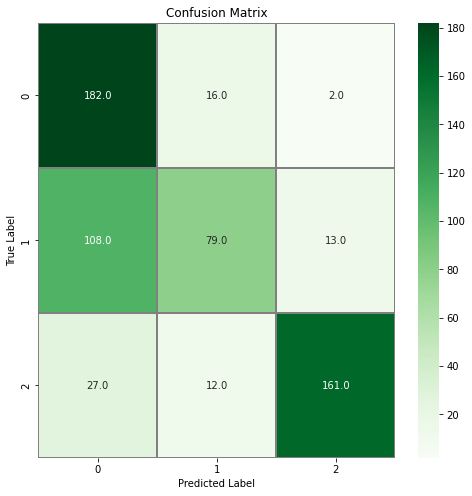

0.7033333333333334


In [131]:
combined_preds_rec = []
pred_final_rec = []
for i in range(0,600,1):
    res1 = pred_labels_ResNet[i]
    res2 = pred_labels_EfficientNetAdam[i]
    res3 = pred_labels_CNN[i]
    combined_preds_rec.append([[res1, res2, res3]])
    

combined_preds_rec = np.array(combined_preds_rec)
print("Shape of combined results: {0}".format(combined_preds_rec.shape))

for i in range(0,600,1):
    pred_results_rec = majority_voting(combined_preds_rec[i])
    pred_final_rec.append(pred_results_rec)
    
plot_confusion_matrix(test_labels, pred_final_rec)
print(accuracy_score(test_labels, pred_final_rec))

* all 5 models


Shape of combined results: (600, 1, 5)
[1, 3, 1] 1
[1, 2, 2] 1
[3, 0, 2] 0
[0, 4, 1] 1
[3, 1, 1] 0
[1, 2, 2] 1
[0, 0, 5] 2
[3, 1, 1] 0
[0, 0, 5] 2
[3, 1, 1] 0
[2, 1, 2] 0
[0, 3, 2] 1
[0, 0, 5] 2
[0, 0, 5] 2
[2, 2, 1] 0
[1, 2, 2] 1
[3, 2, 0] 0
[0, 0, 5] 2
[3, 2, 0] 0
[4, 0, 1] 0
[5, 0, 0] 0
[0, 2, 3] 2
[2, 2, 1] 0
[4, 0, 1] 0
[1, 1, 3] 2
[0, 0, 5] 2
[0, 5, 0] 1
[5, 0, 0] 0
[4, 1, 0] 0
[0, 4, 1] 1
[0, 1, 4] 2
[2, 1, 2] 0
[3, 2, 0] 0
[1, 3, 1] 1
[0, 4, 1] 1
[3, 0, 2] 0
[1, 1, 3] 2
[5, 0, 0] 0
[3, 0, 2] 0
[0, 0, 5] 2
[5, 0, 0] 0
[2, 2, 1] 0
[2, 0, 3] 2
[3, 0, 2] 0
[5, 0, 0] 0
[0, 5, 0] 1
[0, 3, 2] 1
[0, 0, 5] 2
[5, 0, 0] 0
[4, 0, 1] 0
[0, 0, 5] 2
[0, 0, 5] 2
[0, 1, 4] 2
[5, 0, 0] 0
[3, 1, 1] 0
[0, 0, 5] 2
[4, 1, 0] 0
[5, 0, 0] 0
[0, 0, 5] 2
[1, 3, 1] 1
[0, 1, 4] 2
[2, 2, 1] 0
[3, 2, 0] 0
[1, 3, 1] 1
[1, 0, 4] 2
[0, 0, 5] 2
[1, 3, 1] 1
[1, 2, 2] 1
[0, 0, 5] 2
[0, 0, 5] 2
[3, 1, 1] 0
[4, 0, 1] 0
[0, 0, 5] 2
[0, 1, 4] 2
[3, 1, 1] 0
[4, 1, 0] 0
[3, 1, 1] 0
[2, 2, 1] 0
[2, 2, 1] 0
[3, 2, 0] 0
[

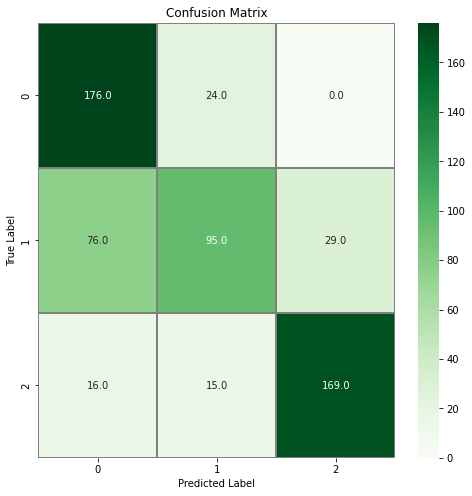

0.7333333333333333


In [132]:
combined_preds_all = []
pred_final_all = []
for i in range(0,600,1):
    res1 = pred_labels_CNN[i]
    res2 = pred_labels_ResNet[i]
    res3 = pred_labels_EfficientNetRMS[i]
    res4 = pred_labels_EfficientNetAdam[i]
    res5 = pred_labels_VGG[i]
    combined_preds_all.append([[res1, res2, res3, res4, res5]])
    

combined_preds_all = np.array(combined_preds_all)
print("Shape of combined results: {0}".format(combined_preds_all.shape))

for i in range(0,600,1):
    pred_results_all = majority_voting(combined_preds_all[i])
    pred_final_all.append(pred_results_all)
    
plot_confusion_matrix(test_labels, pred_final_all)
print(accuracy_score(test_labels, pred_final_all))

Shape of combined results: (600, 1, 4)
[1, 2, 1] 1
[0, 2, 2] 1
[3, 0, 1] 0
[0, 3, 1] 1
[3, 1, 0] 0
[1, 2, 1] 1
[0, 0, 4] 2
[3, 0, 1] 0
[0, 0, 4] 2
[2, 1, 1] 0
[1, 1, 2] 2
[0, 3, 1] 1
[0, 0, 4] 2
[0, 0, 4] 2
[1, 2, 1] 1
[1, 1, 2] 2
[2, 2, 0] 0
[0, 0, 4] 2
[2, 2, 0] 0
[3, 0, 1] 0
[4, 0, 0] 0
[0, 2, 2] 1
[1, 2, 1] 1
[3, 0, 1] 0
[1, 1, 2] 2
[0, 0, 4] 2
[0, 4, 0] 1
[4, 0, 0] 0
[3, 1, 0] 0
[0, 3, 1] 1
[0, 0, 4] 2
[2, 1, 1] 0
[2, 2, 0] 0
[0, 3, 1] 1
[0, 3, 1] 1
[3, 0, 1] 0
[1, 1, 2] 2
[4, 0, 0] 0
[2, 0, 2] 0
[0, 0, 4] 2
[4, 0, 0] 0
[2, 1, 1] 0
[2, 0, 2] 0
[3, 0, 1] 0
[4, 0, 0] 0
[0, 4, 0] 1
[0, 3, 1] 1
[0, 0, 4] 2
[4, 0, 0] 0
[3, 0, 1] 0
[0, 0, 4] 2
[0, 0, 4] 2
[0, 1, 3] 2
[4, 0, 0] 0
[2, 1, 1] 0
[0, 0, 4] 2
[3, 1, 0] 0
[4, 0, 0] 0
[0, 0, 4] 2
[1, 2, 1] 1
[0, 0, 4] 2
[1, 2, 1] 1
[3, 1, 0] 0
[1, 2, 1] 1
[1, 0, 3] 2
[0, 0, 4] 2
[0, 3, 1] 1
[1, 1, 2] 2
[0, 0, 4] 2
[0, 0, 4] 2
[2, 1, 1] 0
[3, 0, 1] 0
[0, 0, 4] 2
[0, 1, 3] 2
[2, 1, 1] 0
[3, 1, 0] 0
[3, 0, 1] 0
[2, 1, 1] 0
[2, 1, 1] 0
[3, 1, 0] 0
[

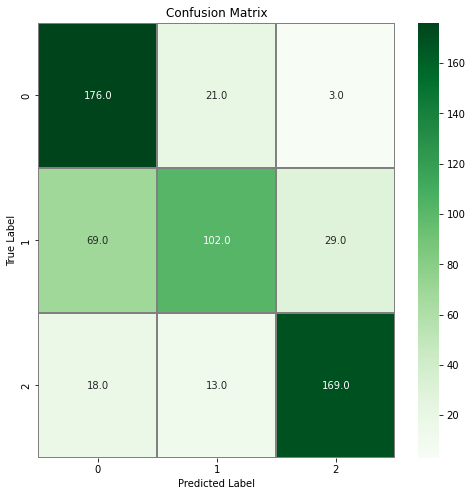

0.745


In [133]:
combined_preds_all = []
pred_final_four = []
for i in range(0,600,1):
    res1 = pred_labels_CNN[i]
    res2 = pred_labels_ResNet[i]
    res3 = pred_labels_EfficientNetAdam[i]
    res4 = pred_labels_VGG[i]
    combined_preds_all.append([[res1, res2, res3, res4]])
    

combined_preds_all = np.array(combined_preds_all)
print("Shape of combined results: {0}".format(combined_preds_all.shape))

for i in range(0,600,1):
    pred_results_four = majority_voting(combined_preds_all[i])
    pred_final_four.append(pred_results_four)
    
plot_confusion_matrix(test_labels, pred_final_four)
print(accuracy_score(test_labels, pred_final_four))